In [435]:
import igl
import numpy as np
import networkx as nx
from meshplot import plot
import drawSvg as draw

def add_edges_from_mesh(G,f):
    m,n = igl.triangle_triangle_adjacency(f)
    for face_id, face in enumerate(f):
        for j, ajd_face_id in enumerate(m[face_id]):
            G.add_edge(face_id,ajd_face_id)

# adds nodes to graph G for every face in mesh
def add_nodes_from_mesh(G,f): [G.add_node(face_id) for face_id, face in enumerate(f)]

# create networkx graph from given mesh
def graph_from_mesh(v,f):
    G = nx.Graph()
    add_nodes_from_mesh(G,f)
    add_edges_from_mesh(G,f)
    return G

# returns a rotation matrix from a (unnormalized) axis and an angle
def get_rotation_matrix(axis, angle):
    from scipy.spatial.transform import Rotation
    return Rotation.from_rotvec(axis/np.linalg.norm(axis) * angle).as_matrix()

# returns a matrix that maps 3D space onto a 2D plane (the orientation of which is specified by 'face_normal').
def get_2d_projection(face_normal):
    z_axis = np.array([0,0,1])
    rotation_axis = np.cross(face_normal, z_axis)
    angle = np.arccos(np.clip(np.dot(z_axis, face_normal), -1.0, 1.0))

    discard_z_matrix = np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])

    rotation_matrix = get_rotation_matrix(rotation_axis, angle)
    return discard_z_matrix.dot(rotation_matrix)


In [450]:
# load mesh
raw_v, raw_f = igl.read_triangle_mesh("sphere.stl")
v, f, _ = igl.remove_duplicates(raw_v, raw_f, 0.00001)


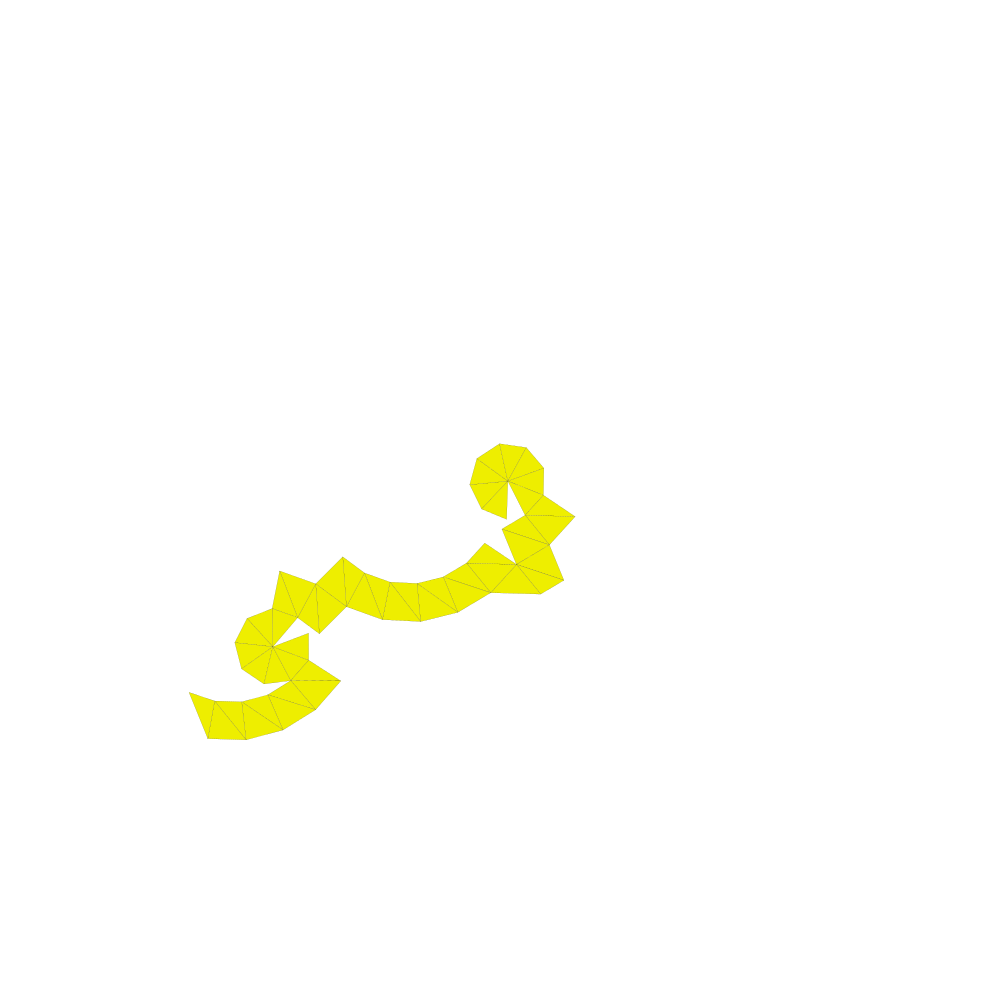

In [451]:
# find commone edge of two adjacent faces
def find_common_edge(f, face_id_a, face_id_b):
    # make sure that the resulting vertex ids are clockwise wrt. source face
    face_vertex_array_a = f[face_id_a]
    face_vertex_array_b = f[face_id_b]

    for i in range(3):
        if face_vertex_array_a[i] in face_vertex_array_b and face_vertex_array_a[(i+1) % 3] in face_vertex_array_b:
            return (face_vertex_array_a[i], face_vertex_array_a[(i+1) % 3])

    return None

def get_face_normal(v, f, face_id):
    face_normals = igl.per_face_normals(v, f, np.ones((1, 3)))
    return face_normals[face_id]

# get angle between the normals of two faces
def dihedral_angle(v, f, face_a_id, face_b_id):
    face_normals = igl.per_face_normals(v, f, np.ones((1, 3)))
    return np.arccos(np.clip(np.dot(face_normals[face_a_id], face_normals[face_b_id]), -1.0, 1.0))

def unfold(v, f):
    polygons = []  # resulting polygons, represented as lists of 2D coordinates

    source_face_id = 0
    parent_dict = nx.dfs_predecessors(graph_from_mesh(v, f), source=source_face_id)
    parent_dict[source_face_id] = None  # add the source face, as networkX is not doing this by default

    for face_id, parent_face_id in parent_dict.items():
        # retrieve the coordinates of current face
        face_coordinates = [v[vertex_id] for vertex_id in f[face_id]]
        
        # iterate over all parents and apply unfolding rotations accordingly
        selected_face_id = face_id
        selected_parent_face_id = parent_face_id

        while selected_face_id != source_face_id:
            # get edge between selected face and parent as tuple of two vertex_ids
            hinge_edge = find_common_edge(f, selected_parent_face_id, selected_face_id)
            
            # apply unfolding transformation:
            # - all face_coordinates are offset such that the hinge_edge aligns with the origin
            # - then, the rotation around the hinge_edge is performed, such that the selected face
            #   and the parent lay in the same plane
            # - finally, we reverse the offset, such that the face ends up in its original position 
            offset = v[hinge_edge[0]]
            rotation_angle = dihedral_angle(
                v, f, selected_face_id, selected_parent_face_id)
            rotation_axis = v[hinge_edge[0]] - v[hinge_edge[1]]
            rotation_matrix = get_rotation_matrix(rotation_axis, rotation_angle)

            for i in range(3):
                face_coordinates[i] = rotation_matrix.dot(face_coordinates[i] - offset) + offset

            # traverse up the tree
            selected_face_id = selected_parent_face_id
            selected_parent_face_id = parent_dict[selected_parent_face_id]

        # project 3D coordinates into the 2D plane that 
        for i in range(3):
            face_coordinates[i] = get_2d_projection(get_face_normal(v, f, source_face_id)).dot(face_coordinates[i])
            
        polygons.append(face_coordinates)

    return polygons


polygons = unfold(v, f)

# generate svg visualization
drawing = None
drawing = draw.Drawing(1000, 1000, origin='center')
for polygon in polygons:
    # polygon = [coords[0:2] for coords in polygon]
    drawing.append(draw.Lines(*np.array(polygon).flatten()*50,
                   close=True, fill='#eeee00', stroke='#000', stroke_width=.1))

drawing
